# Regularized Logistic Regression Example for Cohort Analysis

This notebook provides the code for running a logistic regression analysis against user-sex and insuline resistance as reported in the PHD-Paper.

# Setup

set path to `data.csv` and `metadata.csv` here

In [1]:
PATH = './'

# Imports

In [2]:
import pandas as pd
import json
import string
import pickle
import argparse
import sys, os
from collections import OrderedDict
from sklearn.linear_model import LassoCV, LogisticRegressionCV, RidgeCV, RidgeClassifierCV, MultiTaskLassoCV, LogisticRegression
from sklearn.model_selection import train_test_split, GroupShuffleSplit, StratifiedShuffleSplit, KFold, RepeatedKFold
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_curve, auc, f1_score, classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer
from sklearn import preprocessing
from adjustText import adjust_text
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.pyplot as plt
import matplotlib
import datetime

import random
import numpy as np

In [3]:
today = datetime.datetime.now()

In [4]:
# SET SEED:
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = '42'

In [5]:
# TEST SEED
hash1 = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
hash1

'XAJI0'

In [6]:
color_dict  = {
    "turk": "#10696F",
    "red": "#7e0d0a",
    "blue": "#20627f",
    "green": "#4b7432",
    "orange": "#c05809",
    "yellow": "#c49b10",
    "grey": "#CCCCCC",
    "lturk": "#1aa8b2",
    "lred": "#ad120e",
    "lblue": "#2f92bc",
    "lgreen": "#6daa49",
    "lorange": "#f57c20",
    "lyellow": "#EEC333",
    "lgrey": "#666666"  
}
color_list = [*color_dict.values()]

# 1 Preprocessing

In [7]:
data = pd.read_csv(os.path.join(PATH, 'data.csv'))
data['date_time'] = pd.to_datetime(data['date_time'])
data = data.set_index('date_time')

In [8]:
pid_to_int = OrderedDict([(pid, i) for i, pid in enumerate(data['PID'].unique())])

### Calculate the features

In [9]:
def calculate_ff_sleep_save(data, granularity=20, fillna=True):
    """
    This function calculates the funny features.

    calculates:
      R - avg HR
      R - avg resting HR
        - avg sleeping HR
        - day night difference in HR (avg day vs avg night)
      R - nr of steps per day -> sum(steps)
      R - nr of steps outliers -> X > 2sigma

    and a number of percentage of outliers (of datapoints that day) over the whole distribution of the PID
    """
    nice_feature_names = OrderedDict([
        ('heart_rate', 'Heart rate'),
        ('resting heart_rate', 'Resting heart rate'),
        ('active_heart_rate', 'Active heart rate'),
        ('sleeping_heart_rate', 'Sleeping heart rate'),
        ('steps', 'Total steps'),
        ('total_sleep_hours', 'Sleep hours'),
        ('active_sleep_change_HR', 'Change in heart rate active/sleep'),
        ('POO_heart_rate', '% of outliers in heart rate'),
        ('POO_resting_heart_rate', '% of outliers in resting heart rate'),
        ('POO_active_heart_rate', '% of outliers in active heart rate'),
        ('POO_sleeping_heart_rate', '% of outliers in sleeping heart rate'),
        ('POO_sleep', '% of outliers in sleeping hours'),
        ('POO_steps', '% of outliers in steps'),
    ])

    def _calc_POO(valid_dates, df, p):
        """
        calculates the percentage of outliers per day
        :param df: the dataframe with calucalted Z_scores
        :return:
        """
        perc_of_outlier_per_day = OrderedDict()
        for date_time, date_df in df.groupby(pd.Grouper(freq='D')):
            date = date_time.date()
            if date in valid_dates:
                n_outliers = len(date_df.loc[date_df['Z_%s' % p] > 2])
                try:
                    perc_outliers = n_outliers/len(date_df)
                except ZeroDivisionError:
                    raise NotImplementedError('THis case should never happen, bc valid days are clean in cohort mode (->filtered)')
                    perc_outliers = np.nan
                perc_of_outlier_per_day[date] = perc_outliers
            else:
                perc_of_outlier_per_day[date] = np.nan

        poo_df = pd.DataFrame.from_dict(perc_of_outlier_per_day, orient='index')
        poo_df.columns = ['POO_%s' % p]
        return poo_df


    dates = set(np.unique([d.date() for d in data.index]))
    in_params = [c for c in data.columns if c != 'sleep']

    # open the feature df by calc the avgs per day:
    ffeatures = data.groupby(pd.Grouper(freq='D')).mean() # we assume that if we have sleep, it is numeric.
    ffeatures['sleep'] = data.groupby(pd.Grouper(freq='D')).sum()['sleep'] / (60/granularity)
    ffeatures['steps'] = data.groupby(pd.Grouper(freq='D')).sum()['steps'] * granularity

    # track what we want to get % of outliers from:
    poo_params = [c for c in ffeatures.columns]

    # now partition the data by steps:
    active_data = data.loc[data['steps'] > 0.].loc[:, ['heart_rate']]
    active_data.columns = ['active_heart_rate']
    ffeatures['active_heart_rate'] = active_data.groupby(pd.Grouper(freq='D')).mean()
    poo_params.append('active_heart_rate')

    resting_data = data.loc[data['steps'] == 0.].loc[:, ['heart_rate']]
    resting_data.columns = ['resting_heart_rate']
    ffeatures['resting_heart_rate'] = resting_data.groupby(pd.Grouper(freq='D')).mean()
    poo_params.append('resting_heart_rate')

    data = pd.concat([data, active_data, resting_data], axis=1)

    # now get the outliers for the first round:
    for p in poo_params:
        # get z_score:
        data.loc[:, 'Z_%s' % p] = (data[p] - data[p].mean())/data[p].std(ddof=1)
        # get  poo:
        poo_df = _calc_POO(dates, data, p)
        data.drop('Z_%s' % p, axis=1, inplace=True)
        ffeatures = pd.concat([ffeatures, poo_df], axis=1)

    # incorporate sleep:
    sleep_params = ['sleeping_heart_rate']
    if data['sleep'].nunique() == 2:
        # use the binary sleep data:
        resting_data = data.loc[data['steps'] == 0.].copy()
        sleep_resting_data = resting_data[resting_data['sleep'] > 0.].loc[:, ['heart_rate']]
        sleep_resting_data.columns = ['sleeping_heart_rate']
        ffeatures['sleeping_heart_rate'] = sleep_resting_data.groupby(pd.Grouper(freq='D')).mean()
        ffeatures['active_sleep_change_HR'] = ffeatures['active_heart_rate'] - ffeatures['sleeping_heart_rate']
        ffeatures['total_sleep_hours'] = data.groupby(pd.Grouper(freq='D')).sum()['sleep'] / (60/granularity)

        data = pd.concat([data, sleep_resting_data], axis=1)

        for p in sleep_params:
            # get z_score:
            data.loc[:, 'Z_%s' % p] = (data[p] - data[p].mean())/data[p].std(ddof=1)
            # get  poo:
            poo_df = _calc_POO(dates, data, p)
            data.drop('Z_%s' % p, axis=1, inplace=True)
            ffeatures = pd.concat([ffeatures, poo_df], axis=1)
    else:
        for p in sleep_params:
            ffeatures[p] = np.nan
            ffeatures['POO_%s' % p] = np.nan
        for p in ['active_sleep_change_HR', 'total_sleep_hours']:
            ffeatures[p] = np.nan

    # get a date index:
    ffeatures.index = [i.date() for i in ffeatures.index]
    ffeatures.index.name = 'date'

    # drop all dates we did not have in the beginning:
    ffeatures = ffeatures.loc[dates]

    cols = []
    for c in ffeatures.columns:
        if c in nice_feature_names:
            cols.append(nice_feature_names[c])
        else:
            cols.append(c)

    ffeatures.columns = cols

    ffeatures = ffeatures.sort_index()
    ffeatures.reset_index(inplace=True)
    
    for c in ffeatures.select_dtypes(include=['number']):
        if c == 'sleep':
            ffeatures[c].fillna(ffeatures[c].median(), inplace=True)
        else:    
            ffeatures[c].fillna(ffeatures[c].mean(), inplace=True)

    return ffeatures

In [10]:
data.head()

,PID,heart_rate,sleep,steps
date_time,,,,
2018-05-16 00:00:00,0jpk,60.0,1.0,0.0
2018-05-16 00:05:00,0jpk,62.0,1.0,0.0
2018-05-16 00:10:00,0jpk,64.0,1.0,0.0
2018-05-16 00:15:00,0jpk,65.0,1.0,0.0
2018-05-16 00:20:00,0jpk,66.0,1.0,0.0


In [11]:
ffts = []

for pid, i in pid_to_int.items():
    pid_data = data[data['PID'] == pid]
    pid_ffeatures = calculate_ff_sleep_save(pid_data.drop('PID', axis=1), 
                                            granularity=5)
    pid_ffeatures['PID'] = pid
    ffts.append(pid_ffeatures)
    
ffts = pd.concat(ffts, axis=0)

/home/hduser/miniconda3/envs/clam_dev/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  # Remove the CWD from sys.path while we load stuff.


In [12]:
ffts = ffts.set_index(['PID', 'date'])

In [13]:
ffts.drop(['% of outliers in sleeping hours','sleep'], axis=1, inplace=True)

### meta data

In [14]:
meta_df = pd.read_csv(os.path.join(PATH, 'metadata.csv'
                                  ))
meta_df = meta_df.set_index('PID')
meta_df = meta_df.loc[list(set(meta_df.index.values).intersection(pid_to_int.keys()))]

In [15]:
n_days_pPID = ffts.groupby(ffts.index.get_level_values('PID')).apply(lambda x: x.shape[0])
meta_df['n_days'] = np.nan
for pid in n_days_pPID.index:
    meta_df.loc[pid, 'n_days'] = n_days_pPID.loc[pid]
meta_df = meta_df.dropna(subset=['n_days'])

In [16]:
meta_df.query('n_days<25')

,Age_today,Gender,IRvsIS,A1c,n_days
PID,,,,,
tgiq,49.353425,0.0,1.0,5.7,22.0
sk28,50.671233,1.0,1.0,5.7,19.0
0fn9,NaN,NaN,NaN,NaN,19.0
bdw2,NaN,NaN,NaN,NaN,10.0
jh75,NaN,NaN,NaN,NaN,11.0
v30t,NaN,NaN,NaN,NaN,17.0


# 3 Logistic Regression

In [17]:
# TEST SEED
hash2 = ''.join(random.choices(string.ascii_uppercase + string.digits, k=5))
hash2

'Y6DPB'

In [18]:
from scipy.stats import sem

color_list = ['#F28E85', '#8EB6F8', '#daebd4', ]
def make_barplot(performance_dict, metric='metric', std=True):
        fig, ax = plt.subplots(1, figsize=(2,4))
        models = performance_dict.keys()
        vals = [np.mean(performance_dict[mo][metric]) for mo in models]
        stds = [np.std(performance_dict[mo][metric]) for mo in models]
        sems = [sem(performance_dict[mo][metric], axis=None, ddof=0) for mo in models]
        xs = [*range(len(models))]
        ax.bar(x=xs, height=vals, 
               yerr=stds if std else sems, 
               color=[color_list[i] for i in range(len(models))])
        for i in range(len(models)):
            weight = "normal"
            ax.text(x=i,
                    y=0.95,
                    s="{:.2f}".format(vals[i]),
                    horizontalalignment='center',
                    fontweight=weight)
        ax.set_ylabel(metric)
        ax.set_xticks(xs)
        ax.set_xticklabels([*performance_dict.keys()], rotation=60, horizontalalignment="right")
        ax.set_yticks(np.arange(0, 1.2, 0.2))
        ax.set_title(metric)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
        return fig
        
def set_box_color(bp, color):
    for b in bp['boxes']:
        b.set_facecolor(color)
    plt.setp(bp['medians'], color='black')

def make_boxplot(performance_dict, metric='metric', 
                 std=True):
    fig, ax = plt.subplots(1, figsize=(2,4))
    models = performance_dict.keys()
    vals = np.asarray([performance_dict[mo][metric] for mo in models])
    
    xs = [*range(len(models))]
    
    
    for i in range(len(models)):
        b = ax.boxplot(x=vals.tolist()[i],
               positions=[i], 
               patch_artist=True,  # fill with color
                       widths = 0.4
              )
        set_box_color(b, color_list[i])
        weight = "normal"
        ax.text(x=i,
                y=0.93,
                s="{:.2f}".format(np.mean(vals[i])),
                horizontalalignment='center',
                fontweight=weight)
    ax.set_ylabel(metric)
    ax.set_xticks(xs)
    ax.set_xticklabels([*performance_dict.keys()], rotation=60, horizontalalignment="right")
    ax.set_yticks(np.arange(0, 1.2, 0.2))
    ax.set_title(metric)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    return fig

In [19]:
def map_meta_param(meta_df, param, pid_array, fill=np.nan):
    mapped = []
    for pid in pid_array:
        try:
            mapped.append(meta_df.loc[pid][param])
        except KeyError:
            mapped.append(fill)
    return np.array(mapped)

In [20]:
def percpos(labels):
    return labels.sum()/labels.shape[0]

In [21]:
def calculate_metrics(summary_dict, name=''):
    """
    summary dict:
    {'train_pids': Index([],
       dtype='object', name='PID'),
     'test_pids': Index([],
           dtype='object', name='PID'),
     'model': LogisticRegressionCV(Cs=10, class_weight=None, cv=5, dual=False,
                          fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                          max_iter=500, multi_class='warn', n_jobs=None,
                          penalty='l2', random_state=42, refit=True, scoring=None,
                          solver='lbfgs', tol=0.0001, verbose=0),
     'R2': 0.875,
     'scores': array([[0.50235822, 0.49764178],
            [0.4996584 , 0.5003416 ],
            [0.49749738, 0.50250262],
            [0.50063161, 0.49936839],
            [0.50025308, 0.49974692],
            [0.49603185, 0.50396815],
            [0.49652264, 0.50347736],
            [0.49910291, 0.50089709]]),
     'targets': array([0., 0., 1., 0., 0., 1., 1., 1.])
     }
    """
    performance_dict = {
        'Avg. precision score':[],
        'FPR':[],
        'TPR':[],
        'Recall':[],
        'AUC':[]
    }
    
    
    for summary in summary_dict:
        t = np.concatenate(summary['targets'], axis=0).ravel()
        s = np.concatenate([s[:, 1] for s in summary['scores']], axis=0).ravel()

        prec = average_precision_score(t,
                                       s, 
                                       pos_label=1, average='weighted')
        performance_dict['Avg. precision score'].append(prec)
        fpr, tpr, _ = roc_curve(t, s)
        performance_dict['FPR'].append(fpr)
        performance_dict['TPR'].append(tpr)
        performance_dict['AUC'].append(auc(fpr, tpr))

    return performance_dict

In [22]:
def CV_split_train_summary(ffts, meta_df, col, niter, ndays, from_date=False):
    """
    data is expected to have a mulitlevel index;
    
                   | col 1 | col 2
        ----+------+-------+------
        pid | date | 
    
    run the whole splitting and training within a CV loop.
    """
    run_dict = None
    nsplits = 5
    # 1. outer loop:
    norm_params = ()
    summary = []
    
    label_df = meta_df[[col]]

    # filter the data w/ labels:     
    data = select_n_days(ffts, n_days=ndays)
    data = data.groupby(data.index.get_level_values('PID')).apply(lambda x: x.describe())
    data.index.rename(['PID', 'descriptor'], inplace=True)
    data.drop('count', level='descriptor', inplace=True, axis=0)
    data = data.unstack(level=-1)

    data = data.dropna()
    data = data.loc[label_df[col].dropna().index.values].dropna()
    labels = map_meta_param(label_df, 
                    col, 
                    data.index.get_level_values('PID'), 
                    fill=np.nan)

    # inner loop
    g = RepeatedKFold(n_splits=nsplits, n_repeats=niter)

    for i, (train_index, test_index) in enumerate(g.split(data, labels)):
        if run_dict is None:
            run_dict = {
                    'train_pids': [],
                    'test_pids': [],
                    'scores': [],
                    'targets': [],
                    'model': None
               }
        

        X_train, X_test = data.iloc[train_index], data.iloc[test_index]
        y_train, y_test = labels[train_index], labels[test_index]

        # normalize:
        transformer = preprocessing.PowerTransformer(method='yeo-johnson', standardize=True, copy=True)
        transformer.fit(X_train)
        X_train = pd.DataFrame(transformer.transform(X_train), columns=X_train.columns, index=X_train.index)
        X_train = X_train.dropna()
        X_test = pd.DataFrame(transformer.transform(X_test), columns=X_test.columns, index=X_test.index)

        # train in inner loop:        
        model = LogisticRegression(penalty='elasticnet',
                                                dual=False, 
                                                tol=0.0001, 
                                                C=1.0, 
                                                fit_intercept=True, 
                                                intercept_scaling=1, 
                                                class_weight=None, 
                                                solver='saga', 
                                                max_iter=1000, 
                                                multi_class='auto', 
                                                verbose=0, 
                                                warm_start=False, 
                                                n_jobs=None, 
                                                l1_ratio=0.5)
        model.fit(X_train.values, y_train)
        try:
            run_dict['scores'].append(model.predict_proba(X_test))
        except:
            run_dict['scores'].append(model.predict(X_test))

        run_dict['targets'].append(y_test)
            
        
        if (i+1)%nsplits ==0 and i > 0:
            summary.append(run_dict)
            run_dict = None

    return summary

In [23]:
def select_n_days(ffts, n_days=25):
    """
    Select n days randomly
    """
    selected_days = []

    for pid in ffts.index.get_level_values('PID').unique():
        pid_days = ffts.loc[pid].index.values
        s = len(pid_days) if len(pid_days) < n_days else n_days
        pid_days = pid_days[:s]
        selected_days.extend([(pid, i) for i in pid_days])
        
    # get the subset:
    ffts = ffts.loc[selected_days]
    
    return ffts

### Prepare Labels

In [24]:
meta_df['IRvsIS_inverted'] = (meta_df['IRvsIS']-1).abs()
meta_df['Gender_inverted'] = (meta_df['Gender']-1).abs()

In [25]:
meta_df[['IRvsIS', 'IRvsIS_inverted']].sum()/meta_df['IRvsIS'].dropna().shape[0]

IRvsIS             0.521739
IRvsIS_inverted    0.478261
dtype: float64

In [26]:
meta_df[['Gender_inverted']].sum()/meta_df['Gender'].dropna().shape[0]

Gender_inverted    0.484848
dtype: float64

In [27]:
performances = {}

In [28]:
def run(ffts, meta_df, pid_to_int, col='IRvsIS', ndays=14, niter=10):
    summary = CV_split_train_summary(ffts, meta_df, col=col, niter=niter, 
                                     ndays=ndays, from_date=False)
    performance = calculate_metrics(summary)
    return performance, summary

In [29]:
performances = {}
ndays = 90
niter=10
for col in [
    'IRvsIS_inverted', 
    'Gender_inverted', 
]:
    print(col)
    performance, _= run(ffts, meta_df, 
                        pid_to_int, col, ndays=ndays, niter=niter)
    performances[col] = performance

IRvsIS_inverted
Gender_inverted


# 4 Visualize

In [30]:
p = OrderedDict()
p['Insuline resitance'] = performances['IRvsIS_inverted']
p['Male sex'] = performances['Gender_inverted']

In [31]:
auc_df = pd.DataFrame.from_dict(dict((k, v['AUC']) for k, v in p.items()), orient='index')
avgpr_df = pd.DataFrame.from_dict(dict((k, v['Avg. precision score']) for k, v in p.items()), orient='index')

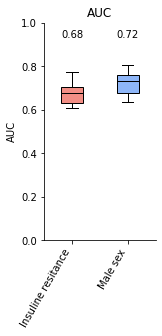

In [32]:
f = make_boxplot(p, metric='AUC', std=False)

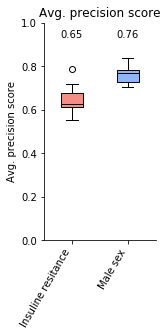

In [33]:
f = make_boxplot(p, metric='Avg. precision score', std=False)